In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import requests

In [3]:
ticker='ECL'
d={'function': 'TIME_SERIES_DAILY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'outputsize':'full'}
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [4]:
#open #high #low #close #adjusted close  #volume #dividend amount
spy=[[],[],[],[],[],[],[]]
for key, val in response.json()['Time Series (Daily)'].items():
    spy[0].append(float(val['1. open']))
    spy[1].append(float(val['2. high']))
    spy[2].append(float(val['3. low']))
    spy[3].append(float(val['4. close']))
    spy[4].append(float(val['5. adjusted close']))
    spy[5].append(float(val['6. volume']))
    spy[6].append(float(val['7. dividend amount']))

In [5]:
spy=pd.DataFrame({'Date':list(response.json()['Time Series (Daily)'].keys()),
                 'open':spy[0],
                  'high':spy[1],
                  'low':spy[2],
                  'close':spy[3],
                  'adj_close':spy[4],
                  'volume':spy[5],
                  'dividend':spy[6],
                 })
spy=spy.astype({'Date': 'datetime64'})


spy=spy.sort_values(by='Date')

In [6]:
spy.head()

,Date,open,high,low,close,adj_close,volume,dividend
5032,2000-05-03,39.50,40.25,39.25,39.88,15.7222,662600.0,0.0
5031,2000-05-04,39.88,40.19,39.44,39.88,15.7222,409500.0,0.0
5030,2000-05-05,39.69,41.13,39.50,40.25,15.8680,420700.0,0.0
5029,2000-05-08,39.88,39.88,38.56,39.25,15.4738,356500.0,0.0
5028,2000-05-09,39.00,40.00,38.69,40.00,15.7695,502700.0,0.0


In [7]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5033 entries, 5032 to 0
Data columns (total 8 columns):
Date         5033 non-null datetime64[ns]
open         5033 non-null float64
high         5033 non-null float64
low          5033 non-null float64
close        5033 non-null float64
adj_close    5033 non-null float64
volume       5033 non-null float64
dividend     5033 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 353.9 KB


In [8]:
spy=spy.astype({'Date': 'datetime64'})

In [9]:
dspy=spy.copy(deep=True)
dspy.set_index('Date', inplace=True)

In [10]:
spy.describe().T

,count,mean,std,min,25%,50%,75%,max
open,5033.0,7.450148e+01,4.655816e+01,24.1000,40.1500,48.8500,1.121600e+02,2.100000e+02
high,5033.0,7.513722e+01,4.689375e+01,24.3900,40.7900,49.3850,1.131300e+02,2.112350e+02
low,5033.0,7.386242e+01,4.621383e+01,23.7800,39.7500,48.4200,1.114500e+02,2.082200e+02
close,5033.0,7.453776e+01,4.657160e+01,24.0000,40.2500,48.9600,1.124100e+02,2.103100e+02
adj_close,5033.0,6.638077e+01,4.999350e+01,12.4527,27.4194,42.1686,1.062558e+02,2.097167e+02
volume,5033.0,1.165211e+06,1.012886e+06,97600.0000,648300.0000,944100.0000,1.406200e+06,2.694340e+07
dividend,5033.0,3.398569e-03,3.083804e-02,0.0000,0.0000,0.0000,0.000000e+00,4.700000e-01


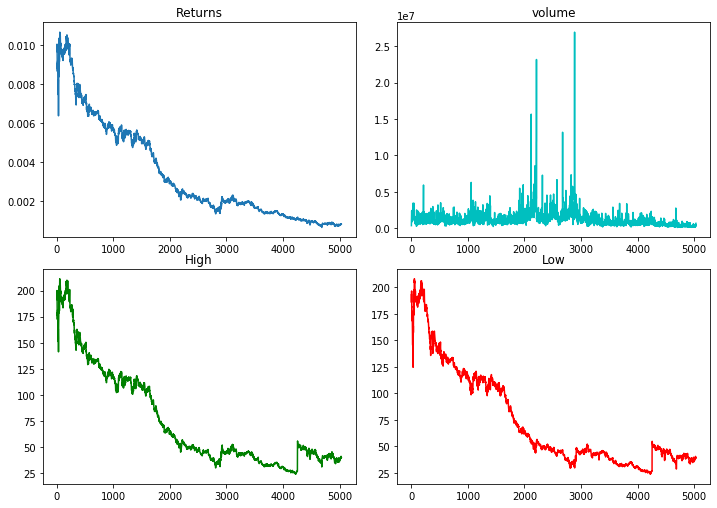

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10,7))
fig.tight_layout()
ax[0][1].plot(spy.volume, color='c')
ax[0][1].set_title("volume");

ax[0][0].plot(spy.adj_close/spy.adj_close[0]/100);
ax[0][0].set_title("Returns");

ax[1][1].plot(spy.low, color='r')
ax[1][1].set_title("Low");

ax[1][0].plot(spy.high, color='g')
ax[1][0].set_title("High");

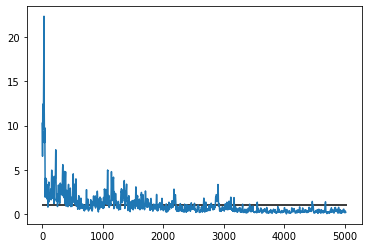

In [13]:
plt.plot(spy.adj_close.rolling(14).std())
np.mean(spy.adj_close.rolling(14).std())
plt.hlines(np.mean(spy.adj_close.rolling(14).std()),0,len(spy))

In [14]:
def std_dev_percentile(x,window):
    x=x.rolling(window).std().dropna().values
    #print(x)
    val=x[-1:]
    return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val


In [15]:
std_dev_percentile(spy.adj_close[-500:],10)

(93.48, array([8.84314681]))

In [16]:
def return_percentile_latest(x,window):
    x=x/x.shift(window)-1
    x=x.dropna().values
    val=x[-1]
    return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val

def return_percentile(x,window,val):
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.percentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.percentile(np.sort(x),val)
        

In [17]:
return_percentile_latest(spy.adj_close,3)#returns percentile and latest value, shift doesn't include current pos
#return_percentile(spy.adj_close,3,1.6)

(75.81, 0.014470284237726228)

### RSI

In [18]:
def RSI(series, period=14):
 print(len(series))
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / pd.stats.moments.ewma(d, com=period-1, adjust=False)
 rs = pd.Series.ewm(u, com=period-1).mean()/pd.Series.ewm(d, com=period-1).mean()
 return 100 - 100 / (1 + rs)

In [19]:
#spy.Close.rolling(14).apply(RSI, raw=False)
#Graph
#min max, %s 
#fit 14 vs 10
#backtested profitability


In [20]:
rsi=RSI(spy.adj_close).dropna();

5033


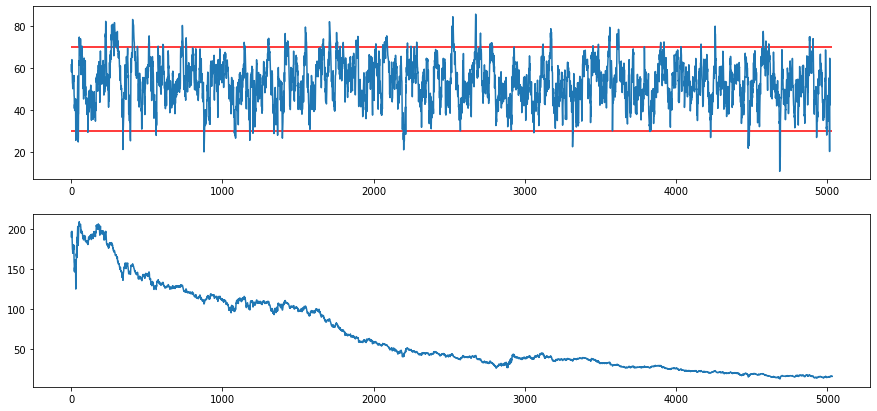

In [21]:
fig, ax= plt.subplots(2,1, figsize=(15,7))
ax[0].plot(rsi)
ax[0].hlines(70,0,len(spy), color='red')
ax[0].hlines(30,0,len(spy), color='red')
ax[1].plot(spy.adj_close);

In [22]:
print("Min RSI", np.min(rsi))
print("Max RSI", np.max(rsi))
print("Median RSI", np.median(rsi))
print("Std dev. RSI", np.std(rsi))
print("% of time below 20", np.round(100*np.sum(np.where(rsi<20,1,0))/len(rsi),2))
print("% of time below 30", np.round(100*np.sum(np.where(rsi<30,1,0))/len(rsi),2))
print("% of time above 70", np.round(100*np.sum(np.where(rsi>70,1,0))/len(rsi),2))
print("% of time above 80", np.round(100*np.sum(np.where(rsi>80,1,0))/len(rsi),2))

Min RSI 10.928063733236925
Max RSI 85.79658663632947
Median RSI 53.5856220621764
Std dev. RSI 10.391333391055909
% of time below 20 0.1
% of time below 30 1.24
% of time above 70 5.46
% of time above 80 0.46


In [23]:
rsi.describe()

count    5019.000000
mean       53.465568
std        10.392369
min        10.928064
25%        46.411762
50%        53.585622
75%        60.617256
max        85.796587
Name: adj_close, dtype: float64

In [24]:
get_percentile(rsi)

(78.36, 61.695723749213364)

### MACD

In [25]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()

In [26]:
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [27]:
macd_hist.describe()

count    5033.000000
mean        0.004127
std         0.476563
min        -6.789330
25%        -0.129517
50%        -0.002045
75%         0.134543
max         5.292967
Name: adj_close, dtype: float64

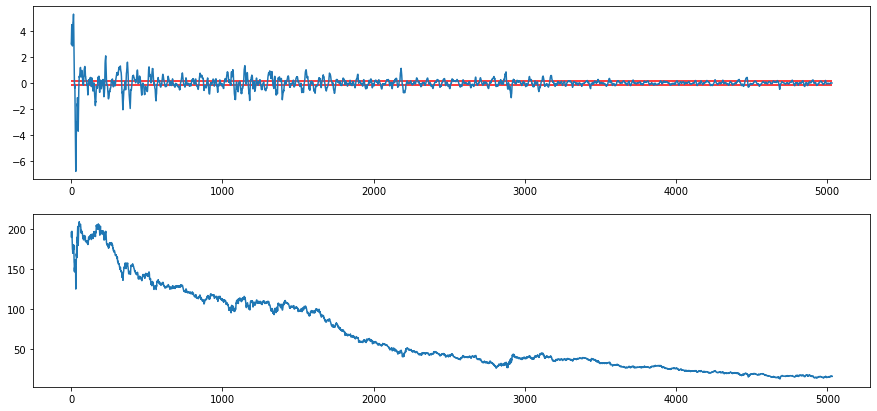

In [28]:
fig, ax= plt.subplots(2,1, figsize=(15,7))
ax[0].plot(macd_hist)
ax[0].hlines(np.percentile(macd_hist,75),0,len(spy), color='red')
ax[0].hlines(np.percentile(macd_hist,25),0,len(spy), color='red')
ax[1].plot(spy.adj_close);

In [29]:
spy['macd']=macd
spy['macd_hist']=macd_hist

In [30]:
dspy['macd']=macd
dspy['macd_hist']=macd_hist

In [31]:
def calcs(x):
    print(x)
    return 0

In [32]:
spy.macd[0]=-1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
results=pd.DataFrame(columns=['start_date','end_date','entry_price','exit_price','is_long'])

In [34]:
def sign_change(x):
    if np.sign(x[0]) == np.sign(x[1]):
        return False
    return True

In [37]:
#On sign change.
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=row.macd
        continue
    if sign_change([last,row.macd]):
        #print(index)
        if has_position:
            #has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.macd>0:
                    is_long=True
                else:
                    is_long=False
        
        else:
            has_position=True
            position_start_index=index
            if row.macd>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.macd                 

In [ ]:
#On sign change buy and below -x sell:
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=row.macd
        continue
    if has_position and row.macd<=-0.2:
        #print(index)
        #if has_position:
            has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            
    elif last<0 and row.macd>=0:
            has_position=True
            position_start_index=index
            if row.macd>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.macd                 

In [35]:
def calc_returns(x):
    if x.is_long==True:
        return np.round(100*(x.exit_price/x.entry_price-1),2)
    return -1*np.round(100*(x.exit_price/x.entry_price-1),2)

In [38]:
#results['returns']=np.round(100*(results.exit_price/results.entry_price-1),2)
results['returns']=results.apply(calc_returns, axis=1)

In [39]:
#results.sort_values(by='returns', ascending=False)
results

,start_date,end_date,entry_price,exit_price,is_long,returns
0,2000-05-05,2000-05-08,15.8680,15.4738,True,-2.48
1,2000-05-08,2000-05-10,15.4738,15.7695,False,-1.91
2,2000-05-10,2000-05-18,15.7695,15.4501,True,-2.03
3,2000-05-18,2000-07-03,15.4501,15.8206,False,-2.40
4,2000-07-03,2000-07-14,15.8206,14.6854,True,-7.18
...,...,...,...,...,...,...
215,2018-12-17,2019-01-18,147.7403,152.5386,False,-3.25
216,2019-01-18,2019-09-11,152.5386,195.6695,True,28.28
217,2019-09-11,2019-12-20,195.6695,190.6805,False,2.55
218,2019-12-20,2020-02-27,190.6805,182.9623,True,-4.05


In [40]:
results.returns.describe()

count    220.000000
mean      -0.935091
std        5.002550
min       -8.880000
25%       -3.420000
50%       -1.950000
75%       -0.530000
max       28.280000
Name: returns, dtype: float64

In [41]:
value_trend=[1000]
for r in results.returns:
    value_trend.append(value_trend[-1]*(1+r/100))

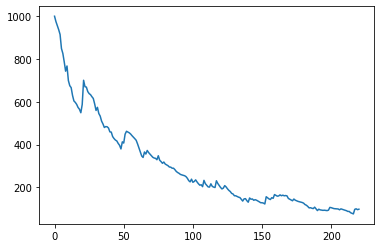

In [42]:
plt.plot(value_trend)

In [43]:
print(f'Returns (%) :', np.round(100*(value_trend[-1]/value_trend[0]-1)))
print(f'SPY returns (%) :', np.round(100*(spy.adj_close[-1:]/spy.adj_close[0]-1)))

Returns (%) : -90.0
SPY returns (%) : 0    0.0
Name: adj_close, dtype: float64


In [44]:
macd_pos=spy.macd[spy.macd>=0]
macd_pos.describe()

count    3187.000000
mean        0.679955
std         0.761563
min         0.000000
25%         0.180117
50%         0.440867
75%         0.879537
max         6.397683
Name: macd, dtype: float64

In [45]:
macd_neg=spy.macd[spy.macd<=0]
macd_neg.describe()

count    1848.000000
mean       -0.572572
std         1.149115
min       -13.932557
25%        -0.582250
50%        -0.234020
75%        -0.101813
max         0.000000
Name: macd, dtype: float64

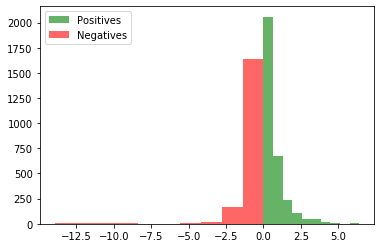

In [46]:
plt.hist(macd_pos, bins=10, alpha=0.6, color='g' ,label='Positives')
plt.hist(macd_neg, bins=10, alpha=0.6, color='r' ,label='Negatives')
plt.legend(loc='upper left');

In [47]:
get_percentile(macd_neg,t='val',val=10)

-1.481406168221477

In [48]:
get_percentile(macd_neg)

(15.69, -1.0)

In [49]:
# macd turning point
#slopes
#value at stage of cycle
# cycle leegth vs depth 

In [50]:
macd_results=pd.DataFrame(columns=['start_date','end_date','is_long','hist','length'])

In [54]:
#### MACD values per cycle
w_macd=[]
cycle_macd_hist=[]
counter=1
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=-1#row[index+1].macd_hist
        continue
    if sign_change([last,row.macd_hist]):
        #print(index)
        if has_position:
            #has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            macd_results=macd_results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'is_long':is_long,'hist':cycle_macd_hist,'length':counter-1}, ignore_index=True)
            counter=1
            if has_position:
                position_start_index=index
                cycle_macd_hist=[]
                cycle_macd_hist.append(row.macd_hist)
                w_macd.append(counter*row.macd_hist)
                counter+=1
                if row.macd_hist>0:
                    is_long=True
                else:
                    is_long=False
                    
        
        else:
            has_position=True
            position_start_index=index
            w_macd.append(counter*row.macd_hist)
            counter+=1
            cycle_macd_hist.append(row.macd_hist)
            if row.macd_hist>0:
                is_long=True
            else:
                is_long=False
            
    elif has_position:
        cycle_macd_hist.append(row.macd_hist)
        w_macd.append(counter*row.macd_hist)
        counter+=1
    last=row.macd_hist                 

In [55]:
macd_results

,start_date,end_date,is_long,hist,length
0,2000-05-05,2000-05-08,True,[0.002756604639287106],1
1,2000-05-08,2000-05-10,False,"[-0.006521948358804585, -0.0009237744532811759]",2
2,2000-05-10,2000-05-17,True,"[0.0017270089607699553, 0.012501692628904852, ...",5
3,2000-05-17,2000-06-28,False,"[-0.000624889646770899, -0.020468002248971218,...",29
4,2000-06-28,2000-07-14,True,"[0.006064565483702239, 0.05082464863370559, 0....",11
...,...,...,...,...,...
391,2019-11-20,2019-12-06,False,"[-0.12337891024381942, -0.5062307062631546, -0...",11
392,2019-12-06,2020-01-07,True,"[0.07731625143629528, 0.12192033890204867, 0.1...",20
393,2020-01-07,2020-01-13,False,"[-0.004255853594240966, -0.16270133114691232, ...",4
394,2020-01-13,2020-02-24,True,"[0.016457135961838787, 0.01043643686542034, 0....",28


In [56]:
w_macd=np.asarray(w_macd)
w_macd[-1:]

array([63.4542371])

In [57]:
np.percentile(w_macd[w_macd<=0],0.5)

-37.628650380914095

### STO

In [58]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'interval':'daily','fastkperiod':22 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

#https://www.alphavantage.co/query?function=STOCH&symbol=SPY&interval=weekly&apikey=YEUC2DL0F7KC43PB&fastkperiod=16

In [59]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

In [60]:
sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })

In [61]:
sto=sto.astype({'Date': 'datetime64'})

In [62]:
spy=spy.merge(sto,left_on='Date',right_on='Date',how='left')

In [63]:
spy['sto_diff']=spy['k']-spy['d']

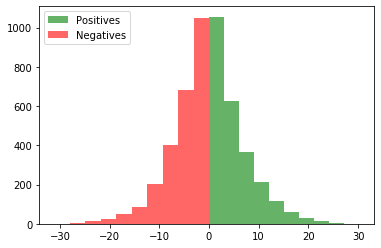

In [64]:
plt.hist(spy.sto_diff[spy.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
plt.hist(spy.sto_diff[spy.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
plt.legend(loc='upper left');

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


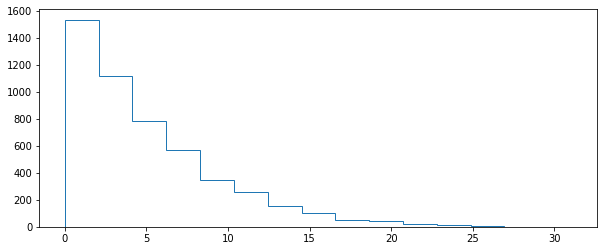

In [65]:
plt.figure(figsize=(10,4))
plt.hist(np.abs(spy.sto_diff), bins=15, histtype='step');

In [66]:
get_percentile(np.abs(spy.sto_diff.dropna()),t='val',val=10)

0.6176800000000015

In [67]:
get_percentile(spy.sto_diff.dropna(),t='val',val=12)

-7.451359999999999

In [68]:
get_percentile(spy.sto_diff[spy.sto_diff>=0].dropna(),t='val',val=99)

20.195798000000025

In [69]:
get_percentile(spy.sto_diff)

(24.55, -4.060500000000005)

In [70]:
spy.dropna().head(5)

,Date,open,high,low,close,adj_close,volume,dividend,macd,macd_hist,k,d,sto_diff
25,2000-06-08,37.81,38.88,36.94,38.44,15.1545,205900.0,0.0,-0.126374,-0.021672,26.0798,27.6538,-1.5740
26,2000-06-09,38.56,38.94,38.19,38.38,15.1308,183700.0,0.0,-0.119642,-0.012615,30.6933,26.9063,3.7870
27,2000-06-12,38.13,38.75,36.88,37.13,14.6380,354600.0,0.0,-0.148235,-0.034809,24.6448,27.1393,-2.4945
28,2000-06-13,37.38,37.63,37.19,37.31,14.7090,317000.0,0.0,-0.163702,-0.042480,16.5228,23.9536,-7.4308
29,2000-06-14,37.38,38.06,37.25,37.69,14.8588,220900.0,0.0,-0.162997,-0.035305,11.9393,17.7023,-5.7630


In [71]:
results=pd.DataFrame(columns=['start_date','end_date','entry_price','exit_price','is_long'])

In [72]:
#On sign change.
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.dropna().iterrows():
    if  index == 1847:
        last=row.sto_diff
        continue
    if sign_change([last,row.sto_diff]):
        #print(index)
        if has_position:
            #has_position=False 
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.sto_diff>0:
                    is_long=True
                else:
                    is_long=False
        
        else:
            has_position=True
            position_start_index=index
            if row.sto_diff>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.sto_diff

In [73]:
def close_position(x,is_long):
    if is_long and x> -6.80:
        return False
    elif ~is_long and x<0:
        return True
    return True

In [74]:
#On sign change buy and below -x sell:

has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.dropna().iterrows():
    if  index == 1847:
        last=row.sto_diff
        continue
    if has_position and row.sto_diff<-6.8:#close_position(row.sto_diff,is_long):
        #print(index)
        #if has_position:
            has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.sto_diff>0:
                    is_long=True
                else:
                    is_long=False
            
    elif ~has_position and last<0 and row.sto_diff>=0:# and index<=1852:

            has_position=True
            position_start_index=index
            if row.sto_diff>0:
                is_long=True
            else:
                is_long=False
                         
    last=row.sto_diff
                               

In [75]:
results['returns']=results.apply(calc_returns, axis=1)

In [76]:
results#.tail(20)

,start_date,end_date,entry_price,exit_price,is_long,returns
0,2000-06-08,2000-06-09,15.1545,15.1308,False,0.16
1,2000-06-09,2000-06-12,15.1308,14.6380,True,-3.26
2,2000-06-12,2000-06-16,14.6380,14.6459,False,-0.05
3,2000-06-16,2000-06-19,14.6459,14.6103,True,-0.24
4,2000-06-19,2000-06-22,14.6103,14.1396,False,3.22
...,...,...,...,...,...,...
1512,2019-11-06,2019-11-11,191.9306,187.8325,True,-2.14
1513,2019-11-14,2019-11-20,190.7370,185.2265,True,-2.89
1514,2019-12-31,2020-01-03,192.4455,188.7859,True,-1.90
1515,2020-02-19,2020-02-24,209.7167,201.9486,True,-3.70


In [77]:
results.returns.describe()

count    1517.000000
mean       -0.455405
std         2.612483
min       -11.730000
25%        -1.760000
50%        -0.750000
75%         0.390000
max        24.950000
Name: returns, dtype: float64

In [78]:
v=1000
value_trend=[]
for r in res:
    value_trend.append(v*(1+r/100))
    v=value_trend[-1]

NameError: name 'res' is not defined

In [ ]:
v

In [ ]:
plt.plot(value_trend)

In [ ]:
spy['k_change'] = spy.k/spy.k.shift(3)-1

In [ ]:
get_percentile(spy.k_change.dropna(),'val',10)

In [79]:
spy.set_index('Date')['2018-7-12':'2018-7-26']

,open,high,low,close,adj_close,volume,dividend,macd,macd_hist,k,d,sto_diff
Date,,,,,,,,,,,,
2018-07-12,142.67,142.8700,142.13,142.66,140.0498,543369.0,0.0,-0.467972,0.353842,54.2249,51.8343,2.3906
2018-07-13,142.85,143.4000,142.61,143.16,140.5406,670932.0,0.0,-0.315546,0.428380,55.4630,53.6589,1.8041
2018-07-16,143.26,143.4100,142.31,142.62,140.0105,689991.0,0.0,-0.234815,0.430786,57.9815,55.8898,2.0917
2018-07-17,142.41,144.0800,142.21,143.72,141.0904,664010.0,0.0,-0.082743,0.493188,61.9074,58.4506,3.4568
2018-07-18,144.00,144.5604,143.52,144.00,141.3652,770199.0,0.0,0.059267,0.537475,67.2537,62.3809,4.8728
2018-07-19,143.15,143.6100,141.83,141.90,139.3037,1148959.0,0.0,0.005402,0.409209,67.5865,65.5826,2.0039
2018-07-20,141.29,141.6200,140.58,140.91,138.3318,1028050.0,0.0,-0.114392,0.244890,59.5274,64.7892,-5.2618
2018-07-23,140.94,141.0800,139.70,140.34,137.7722,877772.0,0.0,-0.251584,0.091129,46.7063,57.9401,-11.2338
2018-07-24,141.12,141.6100,140.24,140.61,138.0373,899929.0,0.0,-0.335056,0.006479,42.1909,49.4749,-7.2840


In [80]:
spy['ret']=100*(spy.adj_close.shift(-4)/spy.adj_close-1)

In [ ]:
res=[]
last=0
for index, row in spy.dropna().iterrows():
    if row.k>40 and spy.loc[last,'k']<40:
        res.append(row.ret)
        #print(row.Date, row.ret)
    last=index            
        

In [ ]:
plt.hist(res);

In [ ]:
pd.DataFrame(res).describe()

### Slope

In [ ]:
np.polyfit(x=[1,2,3,4],y=spy.adj_close.values[-4:],deg=1,full=False)

In [ ]:
plt.plot([1,2,3,4],spy.adj_close.values[-4:])

In [ ]:
spy['std']=spy.Close.rolling(22).apply(np.std, raw=False)

In [ ]:
spy=spy.set_index('Date')

In [ ]:
spy.reset_index(inplace=True)

#price drop, macd hist trough, macd level itself, vol, instead of AMCS signal cycle maybe holding cycle with <-0.3
There will be bad signals, have to make yourown determination
is down x% is what percentile of all x days, maybe VaR*
Not trade high vol situations
does it always cycle down
can repeat with weekly & sto but maybe have to rely on *
pressure release, mean reversion need of the process

so looks like forget predictor, there is not even a good descriptor for quick changes. 
Maybe use vol to describe market, explore shorter MAs for high vol. 
A lot if your skill and estimation.
sentiment maybe something from an unbiased or differentiated source 
stay long buy protection
